<a href="https://colab.research.google.com/github/yamasaki-yu/learning/blob/master/Drawing_Japan_from_JpAddress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

住所データと政府統計データから、日本列島を可視化する<br>

In [184]:
# ライブラリのインポート
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns 

# データの読み込み

## 住所データの読み込み
 [こちら](https://geolonia.github.io/japanese-addresses/)のサービスを利用

In [186]:
# 間引きの割合（1.0=間引かない）
DB_REDUCTION_RATIO = 1.0

# CSVをデータフレームに読みこむ
df_JpAddress = pd.read_csv("https://raw.githubusercontent.com/geolonia/japanese-addresses/master/data/latest.csv")

# 行がめっちゃ多いので間引く
df_JpAddress = df_JpAddress.sample(frac=DB_REDUCTION_RATIO , random_state=0)

# 特定の県を抜き出す場合
#df_JpAddress = df_JpAddress[(df_JpAddress["都道府県名"]=="東京都") & (df_JpAddress["緯度"]>35)]

# 行番号でソートして、行番号を振り直す
df_JpAddress.sort_index(inplace=True)
df_JpAddress.reset_index(drop=True,inplace=True)

df_JpAddress.head()

,都道府県コード,都道府県名,都道府県名カナ,都道府県名ローマ字,市区町村コード,市区町村名,市区町村名カナ,市区町村名ローマ字,大字町丁目コード,大字町丁目名,緯度,経度
0,1,北海道,ホッカイドウ,HOKKAIDO,1101,札幌市中央区,サッポロシチュウオウク,SAPPORO SHI CHUO KU,11010001001,旭ケ丘一丁目,43.042230,141.319722
1,1,北海道,ホッカイドウ,HOKKAIDO,1101,札幌市中央区,サッポロシチュウオウク,SAPPORO SHI CHUO KU,11010001002,旭ケ丘二丁目,43.039768,141.321733
2,1,北海道,ホッカイドウ,HOKKAIDO,1101,札幌市中央区,サッポロシチュウオウク,SAPPORO SHI CHUO KU,11010001003,旭ケ丘三丁目,43.039569,141.319617
3,1,北海道,ホッカイドウ,HOKKAIDO,1101,札幌市中央区,サッポロシチュウオウク,SAPPORO SHI CHUO KU,11010001004,旭ケ丘四丁目,43.038819,141.323040
4,1,北海道,ホッカイドウ,HOKKAIDO,1101,札幌市中央区,サッポロシチュウオウク,SAPPORO SHI CHUO KU,11010001005,旭ケ丘五丁目,43.036547,141.322217


In [187]:
# 変数型と統計量の確認
df_JpAddress_dsc = df_JpAddress.describe()
print(df_JpAddress.dtypes)
df_JpAddress_dsc

都道府県コード        int64
都道府県名         object
都道府県名カナ       object
都道府県名ローマ字     object
市区町村コード        int64
市区町村名         object
市区町村名カナ       object
市区町村名ローマ字     object
大字町丁目コード       int64
大字町丁目名        object
緯度           float64
経度           float64
dtype: object


,都道府県コード,市区町村コード,大字町丁目コード,緯度,経度
count,189539.000000,189539.000000,1.895390e+05,189539.000000,189539.000000
mean,19.343328,19572.265750,1.957227e+11,36.518609,137.369880
std,12.884749,12862.622972,1.286262e+11,3.202640,3.585251
min,1.000000,1101.000000,1.101000e+10,20.425604,122.987678
25%,8.000000,8227.000000,8.227008e+10,34.726770,135.415448
50%,21.000000,21201.000000,2.120104e+11,35.432288,137.081708
75%,28.000000,28109.000000,2.810900e+11,37.454676,140.103353
max,47.000000,47382.000000,4.738200e+11,45.512988,153.980589


## 市町村単位の政府統計データの読み込み
[こちら](https://www.e-stat.go.jp/regional-statistics/ssdsview/municipality)のデータを利用

In [188]:
# CSVをデータフレームに読みこむ
df_localInfo = pd.read_csv("/mystrage/FEI_CITY_200821050002.csv",encoding="shift-jis", thousands=',')
df_localInfo.head()

,調査年 コード,調査年,地域 コード,地域,/項目,A1101_総人口【人】,A1303_65歳以上人口【人】,A6108_昼夜間人口比率【％】,B1101_総面積（北方地域及び竹島を除く）【ｈａ】,B1103_可住地面積【ｈａ】,F1107_完全失業者数【人】,F1109_非労働力人口・家事【人】,G1401_図書館数【館】,I5101_病院数【施設】,I510110_精神科病院数【施設】
0,2015100000,2015年度,1100,北海道 札幌市,NaN,1952356,483534,100.4,112126,"44,036",48619,251107,11,204,25
1,2015100000,2015年度,1101,北海道 札幌市 中央区,NaN,237627,50536,162.7,4642,"2,683",5785,28274,1,37,4
2,2015100000,2015年度,1102,北海道 札幌市 北区,NaN,285321,68960,95.9,6357,"6,319",6615,35910,1,24,5
3,2015100000,2015年度,1103,北海道 札幌市 東区,NaN,261912,61448,94.6,5697,"5,696",6617,31702,1,25,2
4,2015100000,2015年度,1104,北海道 札幌市 白石区,NaN,209584,47879,98.6,3447,"3,441",5719,23374,1,21,3


In [189]:
# 変数型と統計量の確認
print(df_localInfo.dtypes)
df_localInfo.describe()

調査年 コード                         int64
調査年                            object
地域 コード                          int64
地域                             object
/項目                           float64
A1101_総人口【人】                    int64
A1303_65歳以上人口【人】                int64
A6108_昼夜間人口比率【％】               object
B1101_総面積（北方地域及び竹島を除く）【ｈａ】      int64
B1103_可住地面積【ｈａ】                object
F1107_完全失業者数【人】                 int64
F1109_非労働力人口・家事【人】              int64
G1401_図書館数【館】                   int64
I5101_病院数【施設】                   int64
I510110_精神科病院数【施設】              int64
dtype: object


,調査年 コード,地域 コード,/項目,A1101_総人口【人】,A1303_65歳以上人口【人】,B1101_総面積（北方地域及び竹島を除く）【ｈａ】,F1107_完全失業者数【人】,F1109_非労働力人口・家事【人】,G1401_図書館数【館】,I5101_病院数【施設】,I510110_精神科病院数【施設】
count,1.916000e+03,1916.000000,0.0,1.916000e+03,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000,1916.000000
mean,2.015100e+09,21242.400835,NaN,8.068474e+04,20928.507307,20086.960856,1665.512526,9654.835595,1.895616,5.302714,0.650313
std,0.000000e+00,14038.906156,NaN,1.818920e+05,43567.319594,24288.555557,3785.652531,21800.104235,2.744006,11.783832,1.545432
min,2.015100e+09,1100.000000,NaN,0.000000e+00,0.000000,347.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.015100e+09,9279.750000,NaN,9.181500e+03,3206.000000,3956.750000,176.750000,1090.750000,1.000000,1.000000,0.000000
50%,2.015100e+09,20450.500000,NaN,3.015450e+04,8974.500000,10935.500000,605.000000,3579.500000,1.000000,2.000000,0.000000
75%,2.015100e+09,32353.750000,NaN,8.533900e+04,22929.000000,26131.750000,1810.250000,10449.750000,2.000000,6.000000,1.000000
max,2.015100e+09,47382.000000,NaN,3.724844e+06,865490.000000,217761.000000,67778.000000,477434.000000,27.000000,204.000000,25.000000


### データの手直し
欠損値をNaNに統一したり、桁の区切り文字を除去したりしたあとfloatに変換する<br>
外れ値的な地域を除去する<br>

In [190]:

# 欠損値をNaNで置換
df_localInfo['A6108_昼夜間人口比率【％】'] =  df_localInfo['A6108_昼夜間人口比率【％】'].str.replace('-', 'NaN') 
df_localInfo['B1103_可住地面積【ｈａ】'] =  df_localInfo['B1103_可住地面積【ｈａ】'].str.replace('-', 'NaN') 
# 千区切りの , を削除
df_localInfo['A6108_昼夜間人口比率【％】'] =  df_localInfo['A6108_昼夜間人口比率【％】'].str.replace(',', '') 
df_localInfo['B1103_可住地面積【ｈａ】'] =  df_localInfo['B1103_可住地面積【ｈａ】'].str.replace(',', '') 

# floatへ変換
df_localInfo = df_localInfo.astype({'A1101_総人口【人】': float})
df_localInfo = df_localInfo.astype({'A1303_65歳以上人口【人】': float})
df_localInfo = df_localInfo.astype({'A6108_昼夜間人口比率【％】': float})
df_localInfo = df_localInfo.astype({'B1101_総面積（北方地域及び竹島を除く）【ｈａ】': float})
df_localInfo = df_localInfo.astype({'B1103_可住地面積【ｈａ】': float})
df_localInfo = df_localInfo.astype({'F1107_完全失業者数【人】': float})
df_localInfo = df_localInfo.astype({'F1109_非労働力人口・家事【人】': float})
df_localInfo = df_localInfo.astype({'G1401_図書館数【館】': float})
df_localInfo = df_localInfo.astype({'I5101_病院数【施設】': float})
df_localInfo = df_localInfo.astype({'I510110_精神科病院数【施設】': float})

# 外れ値的な地域を除外する
#420 福島県 飯舘村
#418 福島県 葛尾村
df_localInfo.drop(df_localInfo.index[[418,420]], inplace=True)

# 改めてデータの外観確認
print(df_localInfo.dtypes)
df_localInfo.describe()

調査年 コード                         int64
調査年                            object
地域 コード                          int64
地域                             object
/項目                           float64
A1101_総人口【人】                  float64
A1303_65歳以上人口【人】              float64
A6108_昼夜間人口比率【％】              float64
B1101_総面積（北方地域及び竹島を除く）【ｈａ】    float64
B1103_可住地面積【ｈａ】               float64
F1107_完全失業者数【人】               float64
F1109_非労働力人口・家事【人】            float64
G1401_図書館数【館】                 float64
I5101_病院数【施設】                 float64
I510110_精神科病院数【施設】            float64
dtype: object


,調査年 コード,地域 コード,/項目,A1101_総人口【人】,A1303_65歳以上人口【人】,A6108_昼夜間人口比率【％】,B1101_総面積（北方地域及び竹島を除く）【ｈａ】,B1103_可住地面積【ｈａ】,F1107_完全失業者数【人】,F1109_非労働力人口・家事【人】,G1401_図書館数【館】,I5101_病院数【施設】,I510110_精神科病院数【施設】
count,1.914000e+03,1914.000000,0.0,1.914000e+03,1914.000000,1910.000000,1914.000000,1906.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000
mean,2.015100e+09,21256.702194,NaN,8.076902e+04,20950.350052,98.455654,20091.518809,6707.820567,1667.252874,9664.922675,1.897597,5.308255,0.650993
std,0.000000e+00,14039.262771,NaN,1.819684e+05,43584.842142,38.032465,24299.696518,7445.126944,3787.247667,21809.261240,2.744755,11.788743,1.546097
min,2.015100e+09,1100.000000,NaN,0.000000e+00,0.000000,68.600000,347.000000,105.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.015100e+09,9342.250000,NaN,9.208750e+03,3231.750000,89.600000,3956.250000,1985.750000,177.250000,1105.250000,1.000000,1.000000,0.000000
50%,2.015100e+09,20451.500000,NaN,3.018250e+04,9016.500000,96.400000,10935.500000,4110.000000,606.500000,3582.000000,1.000000,2.000000,0.000000
75%,2.015100e+09,32375.250000,NaN,8.563900e+04,22995.000000,101.200000,26133.250000,8473.500000,1810.750000,10463.250000,2.000000,6.000000,1.000000
max,2.015100e+09,47382.000000,NaN,3.724844e+06,865490.000000,1460.600000,217761.000000,80331.000000,67778.000000,477434.000000,27.000000,204.000000,25.000000


# 集計

## 変数作成

In [191]:
# 加工変数の作成
df_localInfo["昼夜間人口比率log10"] = np.log10(df_localInfo["A6108_昼夜間人口比率【％】"])
df_localInfo["６５歳以上比率"] = df_localInfo["A1303_65歳以上人口【人】"]/df_localInfo["A1101_総人口【人】"]
df_localInfo["完全失業者比率"] = df_localInfo["F1107_完全失業者数【人】"]/df_localInfo["A1101_総人口【人】"]
df_localInfo["家事従事者比率"] = df_localInfo["F1109_非労働力人口・家事【人】"]/df_localInfo["A1101_総人口【人】"]
df_localInfo["病院一件あたり面積"] = df_localInfo["B1103_可住地面積【ｈａ】"]/df_localInfo["I5101_病院数【施設】"]
df_localInfo["病院一件あたり面積log10"] = np.log10(df_localInfo["病院一件あたり面積"])
df_localInfo["図書館一件あたり面積"] = df_localInfo["B1103_可住地面積【ｈａ】"]/df_localInfo["G1401_図書館数【館】"]
df_localInfo["図書館一件あたり面積log10"] = np.log10(df_localInfo["図書館一件あたり面積"])
df_localInfo["精神科病院比率"] = df_localInfo["I510110_精神科病院数【施設】"]/df_localInfo["I5101_病院数【施設】"]

## テーブルの横結合
住所データと政府統計のテーブルから必要な変数を抜き出してマージする

In [192]:
# テーブルの横結合

# あらかじめ使用する変数名をリスト化しておく
colname_address = ["都道府県名","市区町村名","市区町村コード","緯度","経度"]
colname_feature = [ "A1101_総人口【人】", 
                   "A6108_昼夜間人口比率【％】",
                   "昼夜間人口比率log10",
                   "６５歳以上比率",
                   "完全失業者比率",
                   "家事従事者比率",
                   "病院一件あたり面積",
                   "病院一件あたり面積log10",
                   "図書館一件あたり面積",
                   "図書館一件あたり面積log10",
                   "精神科病院比率"]

# 住所テーブルから必要な変数を抜き出す
df_address_tmp = df_JpAddress[colname_address]
# 結合用に都道府県名頭2文字＋住所コードの変数を作成
df_address_tmp["結合キー"] = df_JpAddress["都道府県名"].str[:2].str.cat(df_JpAddress["市区町村コード"].astype(str))

# 住所テーブルから必要な変数を抜き出す
df_localInfo_tmp = df_localInfo[["地域","地域 コード"]+colname_feature]
# 結合用に都道府県名頭2文字＋住所コードの変数を作成
df_localInfo_tmp["結合キー"] = df_localInfo["地域"].str[:2].str.cat(df_localInfo["地域 コード"].astype(str))

# マージ
df_merged = pd.merge(df_address_tmp,df_localInfo_tmp, how="left",left_on="結合キー", right_on="結合キー")
df_merged =df_merged[colname_address + colname_feature]
               
df_merged

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,都道府県名,市区町村名,市区町村コード,緯度,経度,A1101_総人口【人】,A6108_昼夜間人口比率【％】,昼夜間人口比率log10,６５歳以上比率,完全失業者比率,家事従事者比率,病院一件あたり面積,病院一件あたり面積log10,図書館一件あたり面積,図書館一件あたり面積log10,精神科病院比率
0,北海道,札幌市中央区,1101,43.042230,141.319722,237627.0,162.7,2.211388,0.212669,0.024345,0.118985,72.513514,1.860419,2683.0,3.428621,0.108108
1,北海道,札幌市中央区,1101,43.039768,141.321733,237627.0,162.7,2.211388,0.212669,0.024345,0.118985,72.513514,1.860419,2683.0,3.428621,0.108108
2,北海道,札幌市中央区,1101,43.039569,141.319617,237627.0,162.7,2.211388,0.212669,0.024345,0.118985,72.513514,1.860419,2683.0,3.428621,0.108108
3,北海道,札幌市中央区,1101,43.038819,141.323040,237627.0,162.7,2.211388,0.212669,0.024345,0.118985,72.513514,1.860419,2683.0,3.428621,0.108108
4,北海道,札幌市中央区,1101,43.036547,141.322217,237627.0,162.7,2.211388,0.212669,0.024345,0.118985,72.513514,1.860419,2683.0,3.428621,0.108108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189534,沖縄県,八重山郡竹富町,47381,24.234027,123.944947,3998.0,105.0,2.021189,0.199600,0.009505,0.060780,inf,inf,inf,inf,NaN
189535,沖縄県,八重山郡竹富町,47381,24.305231,123.685666,3998.0,105.0,2.021189,0.199600,0.009505,0.060780,inf,inf,inf,inf,NaN
189536,沖縄県,八重山郡竹富町,47381,24.472254,123.820428,3998.0,105.0,2.021189,0.199600,0.009505,0.060780,inf,inf,inf,inf,NaN
189537,沖縄県,八重山郡竹富町,47381,24.326125,124.089079,3998.0,105.0,2.021189,0.199600,0.009505,0.060780,inf,inf,inf,inf,NaN


## 変数の概観を確認

### 統計量の取得

In [193]:
#infをのぞいて変数を統計量を確認

df_noInf = df_merged.copy()

# 各変数に対し、無限を-1で置き換える
for colname in colname_feature:
  df_noInf.loc[df_merged[colname] == float('inf'), colname] = np.nan
  df_noInf.loc[df_merged[colname] == float('-inf'), colname] = np.nan

# 基礎統計量を取得
df_noInf_desc = df_noInf.describe()

# 欠損のない変数からレコード数を取得
n_sample = df_noInf_desc.loc["count","市区町村コード"]

# 各変数のデータ数を取得して、そこから欠損数と欠損割合を取得
df_missN = pd.DataFrame(index=[], columns=df_noInf_desc.columns)
for colname in df_noInf_desc.columns:
  df_missN.loc["missing_count",colname] = n_sample - df_noInf_desc.loc["count",colname]
  df_missN.loc["missing_rate[%]",colname] = (n_sample - df_noInf_desc.loc["count",colname]) *100 / n_sample

# 欠損数・欠損割合を統計量のテーブルにマージ
df_noInf_desc = pd.concat([df_noInf_desc,df_missN], axis=0)

df_noInf_desc

,市区町村コード,緯度,経度,A1101_総人口【人】,A6108_昼夜間人口比率【％】,昼夜間人口比率log10,６５歳以上比率,完全失業者比率,家事従事者比率,病院一件あたり面積,病院一件あたり面積log10,図書館一件あたり面積,図書館一件あたり面積log10,精神科病院比率
count,189539,189539,189539,189409,189324,189324,189324,189324,189324,177790,177790,177148,177148,179075
mean,19572.3,36.5186,137.37,152332,101.044,1.99533,0.284339,0.0202763,0.120471,2292.94,3.02652,5419.71,3.51351,0.117434
std,12862.6,3.20264,3.58525,141247,40.9327,0.0716546,0.0558079,0.00435656,0.0166666,3954.6,0.538827,6451.7,0.449668,0.131614
min,1101,20.4256,122.988,0,68.6,1.83632,0.126737,0,0.033119,44.0526,1.64397,105,2.02119,0
25%,8227,34.7268,135.415,44162,91.9,1.96332,0.246638,0.0174984,0.109951,437.432,2.64091,1707,3.23223,0
50%,21201,35.4323,137.082,109801,98.4,1.993,0.274222,0.0200587,0.119174,1031.33,3.0134,3377,3.52853,0.09375
75%,28109,37.4547,140.103,219805,103.1,2.01326,0.315903,0.0226837,0.131124,2578.75,3.41141,6440,3.80889,0.183673
max,47382,45.513,153.981,903346,1460.6,3.16453,0.604851,0.0599012,0.243669,80331,4.90488,80331,4.90488,1
missing_count,0,0,0,130,215,215,215,215,215,11749,11749,12391,12391,10464
missing_rate[%],0,0,0,0.0685875,0.113433,0.113433,0.113433,0.113433,0.113433,6.19872,6.19872,6.53744,6.53744,5.52076


### ヒストグラムの描画

A1101_総人口【人】


<Figure size 720x360 with 0 Axes>

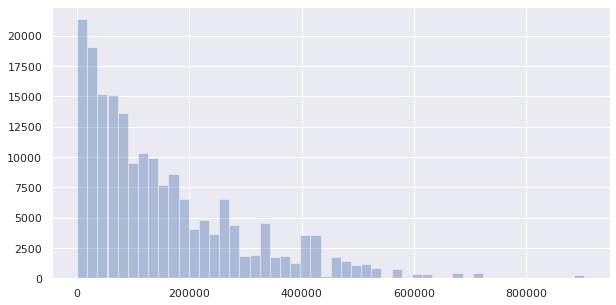

A6108_昼夜間人口比率【％】


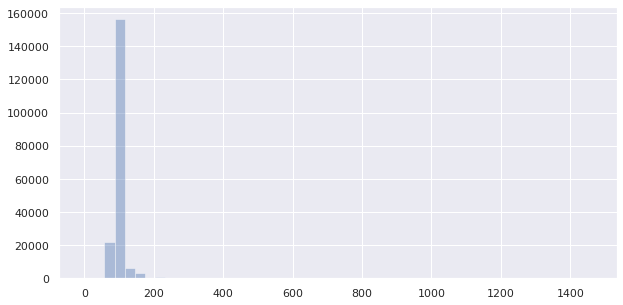

昼夜間人口比率log10


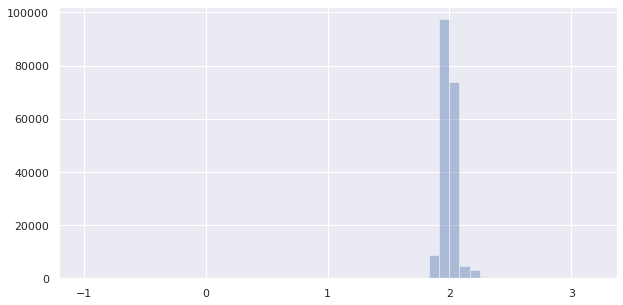

６５歳以上比率


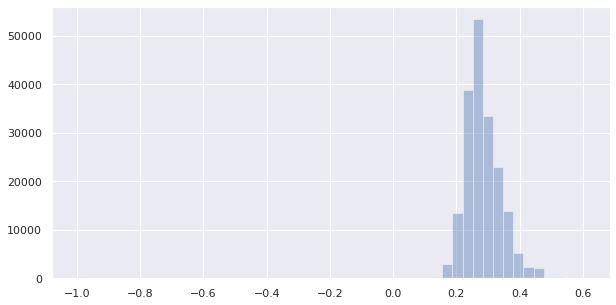

完全失業者比率


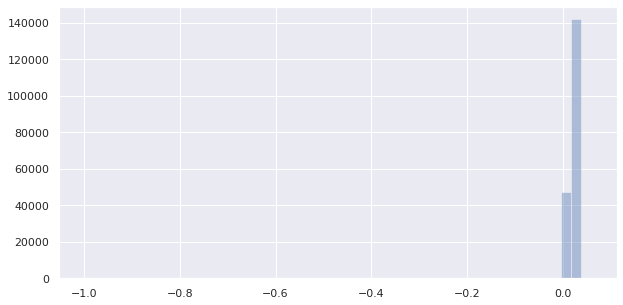

家事従事者比率


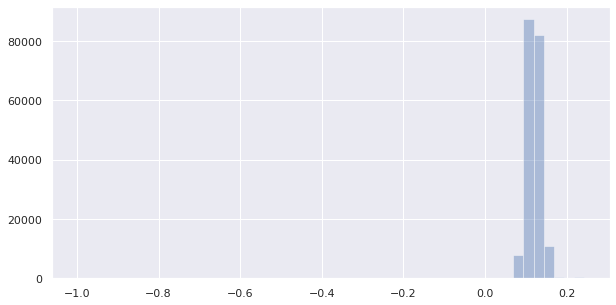

病院一件あたり面積


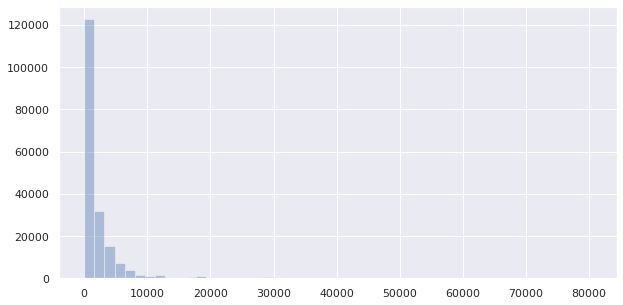

病院一件あたり面積log10


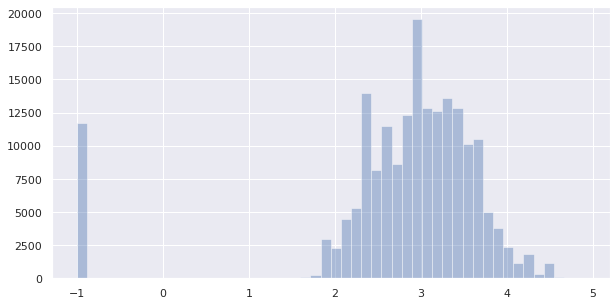

図書館一件あたり面積


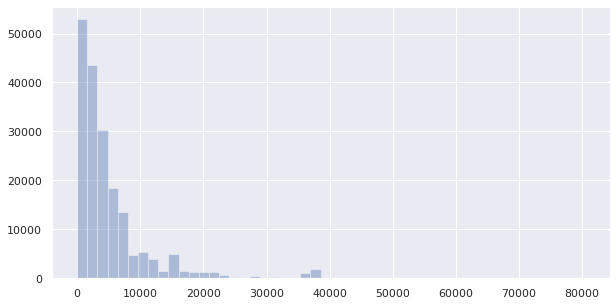

図書館一件あたり面積log10


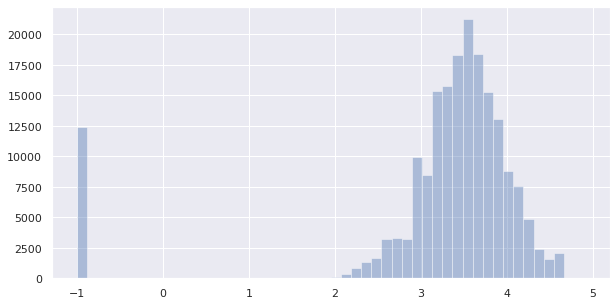

精神科病院比率


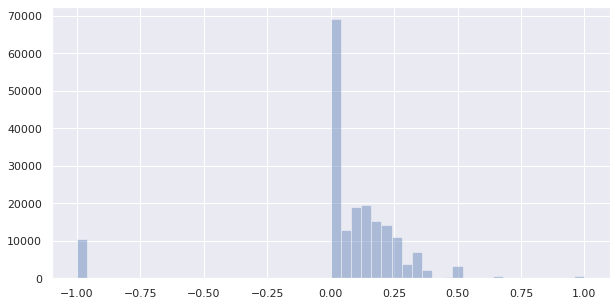

In [194]:
# seabornの設定
sns.set()
plt.rcParams["figure.figsize"] = (10, 5)

# グラフの描画先の準備
fig = plt.figure()

df_histgram = df_merged.copy()

# 各変数に対し、無限を欠損地に置き換え、その後-1を代入する
for colname in colname_feature:
  df_histgram.loc[df_merged[colname] == float('inf'), colname] = np.nan
  df_histgram.loc[df_merged[colname] == float('-inf'), colname] = np.nan
  df_histgram[colname].fillna(-1,inplace=True)

# 各変数のヒストグラムを表示
for colname in colname_feature:
  fig = plt.figure()
  print(colname)
  sns.distplot(df_histgram[colname],kde=False, axlabel="")
  plt.show()
  fig.savefig("/mystrage/hist_" + colname + ".png")



# 日本列島描画

## 変数を0~200に正規化

In [195]:

df_normalized = df_merged[colname_address].copy()

# 各変数ごとの処理
for colname in colname_feature:
  # 最大値と最小値の取得
  max = float(df_merged[colname][df_merged[colname]!=float('inf')].max())
  min = float(df_merged[colname][df_merged[colname]!=float('-inf')].min())
  # 正規化
  df_normalized[colname] = (df_merged[colname]-min) / (max-min) * 200
  # 欠損値は-1で埋める(先に無限を欠損地に置き換え、その後-1うめ)
  df_normalized.loc[df_merged[colname] == float('inf'), colname] = np.nan
  df_normalized.loc[df_merged[colname] == float('-inf'), colname] = np.nan
  df_normalized[colname].fillna(-1,inplace=True)
  # int型にキャスト
  df_normalized[colname] = df_normalized[colname].astype(int)

# 0~200の整数に正規化できていることを確認
print(df_normalized.dtypes , "\n")
print(df_normalized[df_normalized==-1].count() , "\n")
df_normalized.describe()


都道府県名                object
市区町村名                object
市区町村コード               int64
緯度                  float64
経度                  float64
A1101_総人口【人】          int64
A6108_昼夜間人口比率【％】      int64
昼夜間人口比率log10          int64
６５歳以上比率               int64
完全失業者比率               int64
家事従事者比率               int64
病院一件あたり面積             int64
病院一件あたり面積log10        int64
図書館一件あたり面積            int64
図書館一件あたり面積log10       int64
精神科病院比率               int64
dtype: object 

都道府県名                   0
市区町村名                   0
市区町村コード                 0
緯度                      0
経度                      0
A1101_総人口【人】          130
A6108_昼夜間人口比率【％】      215
昼夜間人口比率log10          215
６５歳以上比率               215
完全失業者比率               215
家事従事者比率               215
病院一件あたり面積           11749
病院一件あたり面積log10      11749
図書館一件あたり面積          12391
図書館一件あたり面積log10     12391
精神科病院比率             10464
dtype: int64 



,市区町村コード,緯度,経度,A1101_総人口【人】,A6108_昼夜間人口比率【％】,昼夜間人口比率log10,６５歳以上比率,完全失業者比率,家事従事者比率,病院一件あたり面積,病院一件あたり面積log10,図書館一件あたり面積,図書館一件あたり面積log10,精神科病院比率
count,189539.000000,189539.000000,189539.000000,189539.000000,189539.000000,189539.000000,189539.000000,189539.000000,189539.000000,189539.000000,189539.000000,189539.000000,189539.00000,189539.000000
mean,19572.265750,36.518609,137.369880,33.202934,4.169216,23.419317,65.357615,67.113291,82.395734,4.755538,78.982093,11.855185,96.21087,21.951366
std,12862.622972,3.202640,3.585251,31.262624,5.895315,10.835438,23.448325,14.746507,16.083463,9.652452,38.046893,15.931638,39.62390,26.108403
min,1101.000000,20.425604,122.987678,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000
25%,8227.000000,34.726770,135.415448,9.000000,3.000000,19.000000,50.000000,58.000000,72.000000,0.000000,53.000000,3.000000,79.00000,0.000000
50%,21201.000000,35.432288,137.081708,24.000000,4.000000,23.000000,61.000000,66.000000,81.000000,2.000000,81.000000,7.000000,101.00000,17.000000
75%,28109.000000,37.454676,140.103353,48.000000,4.000000,26.000000,79.000000,75.000000,93.000000,5.000000,106.000000,14.000000,122.00000,34.000000
max,47382.000000,45.512988,153.980589,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000


## 描画範囲と倍率の設定


### 経度・緯度の範囲設定

In [196]:
# 最端から0.1度ほど余裕を持たせる
MARGIN = 0.1

# 原点を取得（南西が原点）
orgPoint_keii = df_JpAddress_dsc["緯度"]["min"] - MARGIN , df_JpAddress_dsc["経度"]["min"] - MARGIN
# 範囲を取得
range_keii = df_JpAddress_dsc["緯度"]["max"] - df_JpAddress_dsc["緯度"]["min"] + MARGIN*2 , df_JpAddress_dsc["経度"]["max"] - df_JpAddress_dsc["経度"]["min"] + MARGIN*2 

print("original point = " ,orgPoint_keii)
print("range = " ,range_keii)

original point =  (20.325604, 122.88767800000001)
range =  (25.287384, 31.192910999999977)


### 画像のサイズ定義と倍率取得


In [197]:
# 最大の横幅を設定
MAX_SIZE_WIDTH = 5000

# 経度・緯度->画素位置　に変換するための倍率を取得
ratio_point2img = MAX_SIZE_WIDTH / range_keii[1]
print(ratio_point2img)

# 画像サイズを計算（経度・緯度の縦横比を保ったまま、横幅がMAX_SIZE_WIDTHの値になるようにする）
imgSize = [int(n*ratio_point2img) for n in range_keii]
print(imgSize)

160.2928306370638
[4053, 5000]


## 住所データの描画

### 画像の初期化


In [198]:

# 描画用画像を初期化
img_point = np.zeros((imgSize[1], imgSize[0], 3), np.uint8)
img_totalPopulation = np.zeros((imgSize[1], imgSize[0], 3), np.uint8)
img_dayPopulationRate = np.zeros((imgSize[1], imgSize[0],3), np.uint8)
img_dayPopulationRate_log10 = np.zeros((imgSize[1], imgSize[0],3), np.uint8)
img_over65Rate = np.zeros((imgSize[1], imgSize[0], 3), np.uint8)
img_lossJobRate = np.zeros((imgSize[1], imgSize[0], 3), np.uint8)
img_housekeepRate = np.zeros((imgSize[1], imgSize[0], 3), np.uint8)
img_areaPer1hospital = np.zeros((imgSize[1], imgSize[0],3), np.uint8)
img_areaPer1hospital_log10 = np.zeros((imgSize[1], imgSize[0],3), np.uint8)
img_areaPer1library = np.zeros((imgSize[1], imgSize[0], 3), np.uint8)
img_areaPer1library_log10 = np.zeros((imgSize[1], imgSize[0], 3), np.uint8)
img_psychiatryRate = np.zeros((imgSize[1], imgSize[0], 3), np.uint8)

# マスク用画像を初期化
img_totalPopulation_mask = np.zeros((imgSize[1], imgSize[0], 1), np.uint8)
img_dayPopulationRate_mask = np.zeros((imgSize[1], imgSize[0],1), np.uint8)
img_dayPopulationRate_mask_log10 = np.zeros((imgSize[1], imgSize[0],1), np.uint8)
img_over65Rate_mask = np.zeros((imgSize[1], imgSize[0],1), np.uint8)
img_lossJobRate_mask = np.zeros((imgSize[1], imgSize[0], 1), np.uint8)
img_housekeepRate_mask = np.zeros((imgSize[1], imgSize[0], 1), np.uint8)
img_areaPer1hospital_mask = np.zeros((imgSize[1], imgSize[0],1), np.uint8)
img_areaPer1hospital_mask_log10 = np.zeros((imgSize[1], imgSize[0],1), np.uint8)
img_areaPer1library_mask = np.zeros((imgSize[1], imgSize[0],1), np.uint8)
img_areaPer1library_mask_log10 = np.zeros((imgSize[1], imgSize[0],1), np.uint8)
img_psychiatryRate_mask = np.zeros((imgSize[1], imgSize[0], 1), np.uint8)

# 描画用画像を初期化
img_totalPopulation_out = np.zeros((imgSize[1], imgSize[0], 1), np.uint8)
img_over65Rate_out = np.zeros((imgSize[1], imgSize[0], 1), np.uint8)
img_dayPopulationRate_out = np.zeros((imgSize[1], imgSize[0],1), np.uint8)
img_dayPopulationRate_out_log10 = np.zeros((imgSize[1], imgSize[0],1), np.uint8)
img_lossJobRate_out = np.zeros((imgSize[1], imgSize[0], 1), np.uint8)
img_housekeepRate_out = np.zeros((imgSize[1], imgSize[0], 1), np.uint8)
img_areaPer1hospital_out = np.zeros((imgSize[1], imgSize[0],1), np.uint8)
img_areaPer1hospital_out_log10 = np.zeros((imgSize[1], imgSize[0],1), np.uint8)
img_areaPer1library_out = np.zeros((imgSize[1], imgSize[0], 1), np.uint8)
img_areaPer1library_out_log10 = np.zeros((imgSize[1], imgSize[0], 1), np.uint8)
img_psychiatryRate_out = np.zeros((imgSize[1], imgSize[0], 1), np.uint8)

# 画像をリスト化
img_list = [
            img_totalPopulation,
            img_dayPopulationRate,
            img_dayPopulationRate_log10,
            img_over65Rate,
            img_lossJobRate,
            img_housekeepRate,
            img_areaPer1hospital,
            img_areaPer1hospital_log10,
            img_areaPer1library,
            img_areaPer1library_log10,
            img_psychiatryRate
            ]

# 画像をリスト化
mask_list = [
            img_totalPopulation_mask,
            img_dayPopulationRate_mask,
            img_dayPopulationRate_mask_log10,
            img_over65Rate_mask,
            img_lossJobRate_mask,
            img_housekeepRate_mask,
            img_areaPer1hospital_mask,
            img_areaPer1hospital_mask_log10,
            img_areaPer1library_mask,
            img_areaPer1library_mask_log10,
            img_psychiatryRate_mask
            ]

# 画像をリスト化
output_list = [
            img_totalPopulation_out,
            img_over65Rate_out,
            img_dayPopulationRate_out,
            img_dayPopulationRate_out_log10,
            img_lossJobRate_out,
            img_housekeepRate_out,
            img_areaPer1hospital_out,
            img_areaPer1hospital_out_log10,
            img_areaPer1library_out,
            img_areaPer1library_out_log10,
            img_psychiatryRate_out
            ]




### 住所の点描


In [199]:

# 処理しやすいように経度・緯度・変数をndarrayで抜き出す
point_list = df_normalized[["緯度" , "経度"] + colname_feature].values
print(point_list)

# 各点ごとの処理
for cnt1, abs_point in enumerate(point_list):

  # 基準経緯度からの相対経緯度を取得
  relative_point = abs_point[:2] - orgPoint_keii

  # ドットを打つ画像上の座標を取得
  dot_point = [int(n*ratio_point2img) for n in relative_point]

  # img_point（変数に関係なく、住所データがある位置に点を打つだけ）に対する処理
  cv2.circle(img_point, (dot_point[1],dot_point[0]), 1, (191, 241, 0), thickness=-1)

  # その他の画像に対する処理
  cnt2 = 0
  for img, mask in zip(img_list,mask_list):
    # 欠損値の場合、マスク画像に欠損であることを記録
    if abs_point[cnt2 + 2] == -1 : 
      cv2.circle(mask, (dot_point[1],dot_point[0]), 1,125 , thickness=-1)
    else : 
      # 点描
      cv2.circle(img, (dot_point[1],dot_point[0]), 1,(abs_point[cnt2 + 2],abs_point[cnt2 + 2],abs_point[cnt2 + 2]) , thickness=-1)
      cv2.circle(mask, (dot_point[1],dot_point[0]), 1,255 , thickness=-1)
    cnt2+=1;

  # 進行状況の表示
  if cnt1 % 10000 == 0 : print(cnt1 , relative_point, dot_point)



[[ 43.04223  141.319722  52.       ...   6.        97.        21.      ]
 [ 43.039768 141.321733  52.       ...   6.        97.        21.      ]
 [ 43.039569 141.319617  52.       ...   6.        97.        21.      ]
 ...
 [ 24.472254 123.820428   0.       ...  -1.        -1.        -1.      ]
 [ 24.326125 124.089079   0.       ...  -1.        -1.        -1.      ]
 [ 24.455925 122.987678   0.       ...  -1.        -1.        -1.      ]]
0 [22.716626 18.432044] [3641, 2954]
10000 [22.579945 20.261795] [3619, 3247]
20000 [24.777142 18.889642] [3971, 3027]
30000 [18.937562 18.6939  ] [3035, 2996]
40000 [18.252351 17.660037] [2925, 2830]
50000 [16.118898 17.135761] [2583, 2746]
60000 [15.458568 17.402509] [2477, 2789]
70000 [15.227016 16.763403] [2440, 2687]
80000 [17.4573   16.310354] [2798, 2614]
90000 [15.288011 13.084692] [2450, 2097]
100000 [15.050581 13.64129 ] [2412, 2186]
110000 [14.573029 14.008092] [2335, 2245]
120000 [14.732462 13.787763] [2361, 2210]
130000 [14.60208  12.812

### 画像の表示

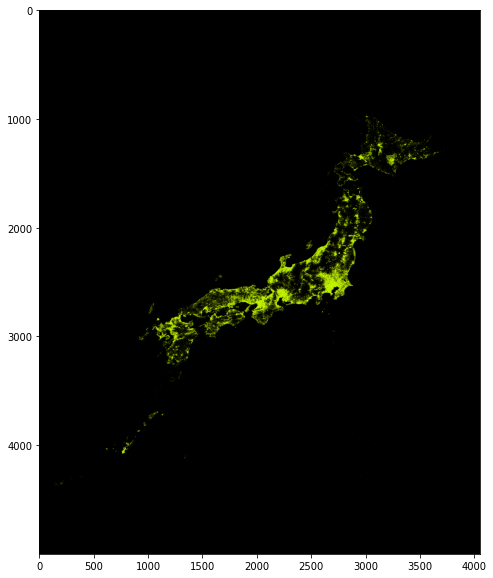

1 A1101_総人口【人】


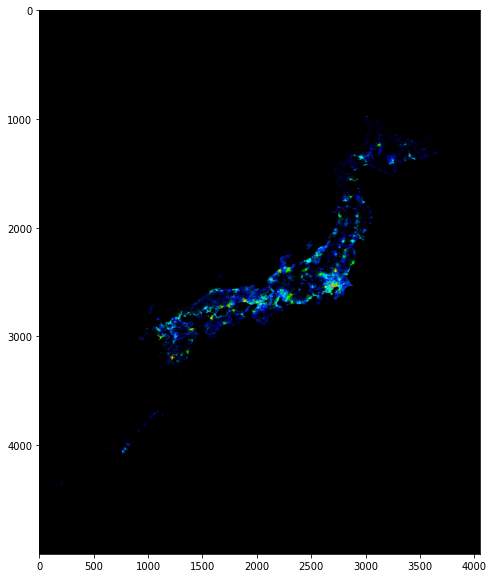

2 A6108_昼夜間人口比率【％】


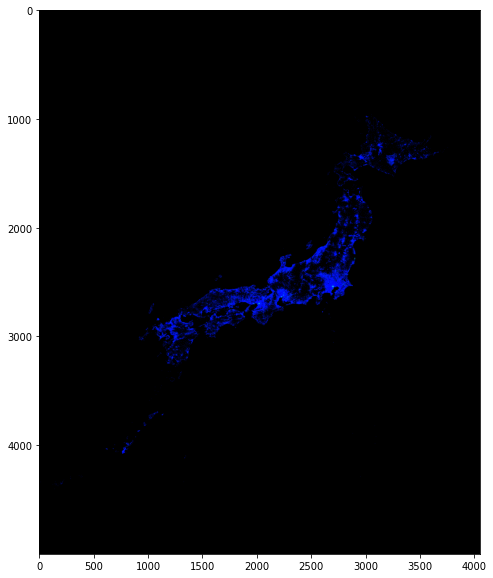

3 昼夜間人口比率log10


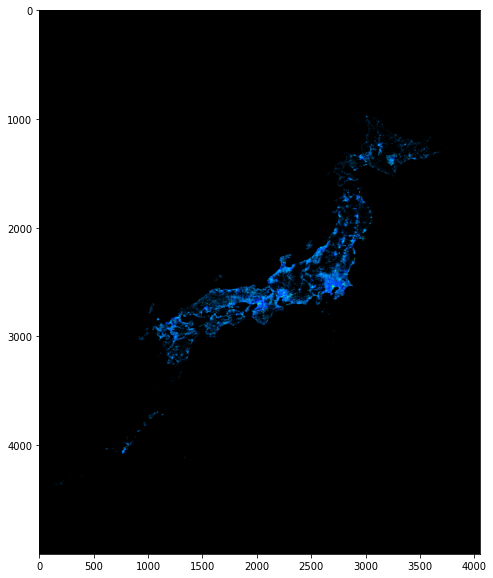

4 ６５歳以上比率


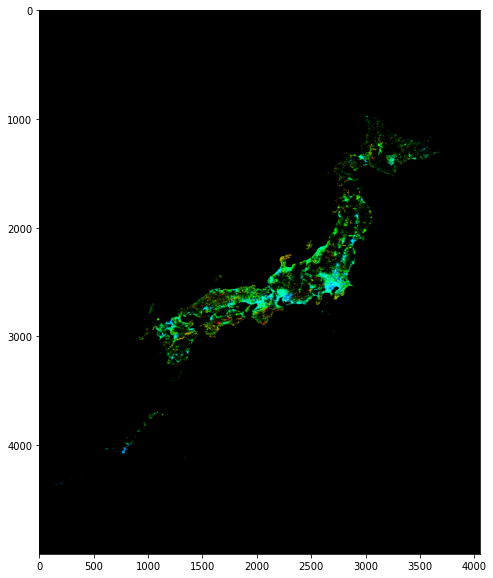

5 完全失業者比率


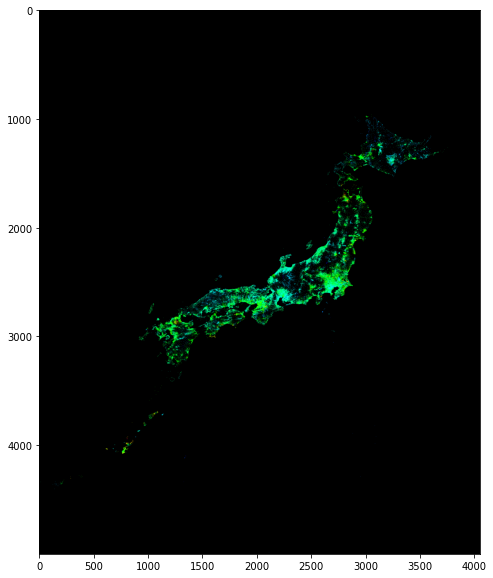

6 家事従事者比率


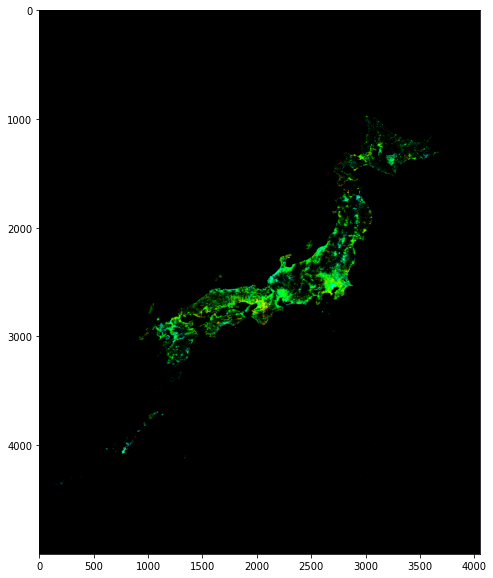

7 病院一件あたり面積


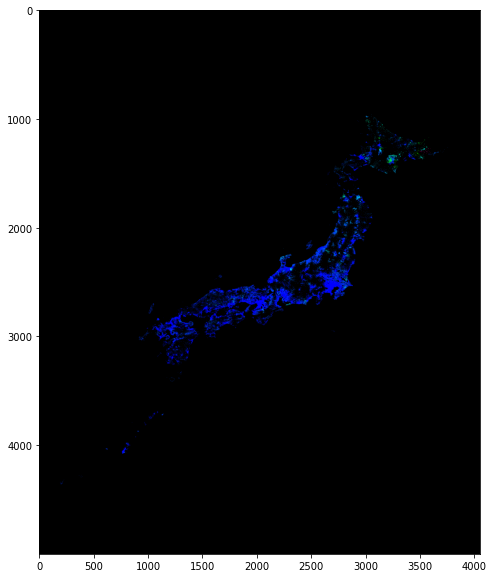

8 病院一件あたり面積log10


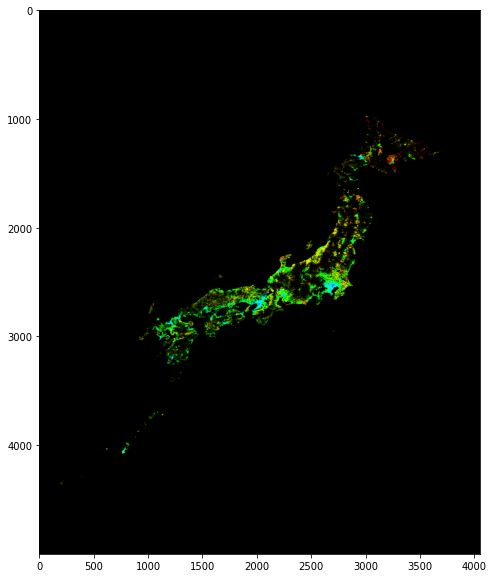

9 図書館一件あたり面積


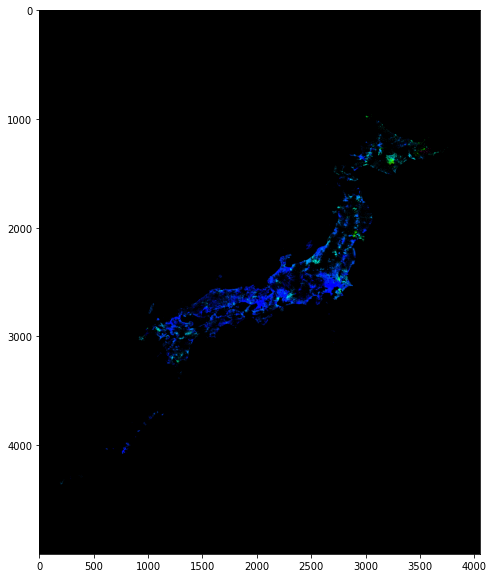

10 図書館一件あたり面積log10


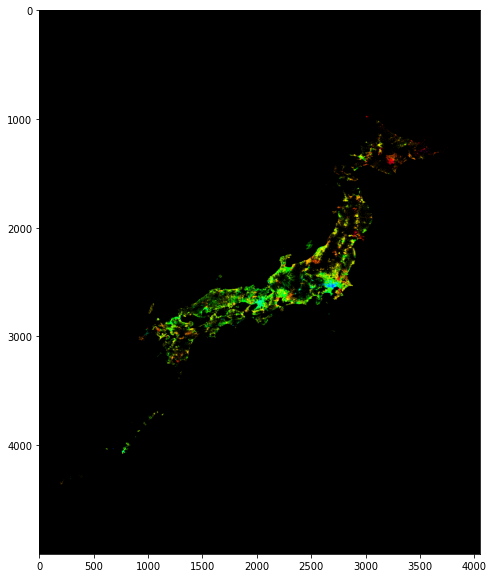

11 精神科病院比率


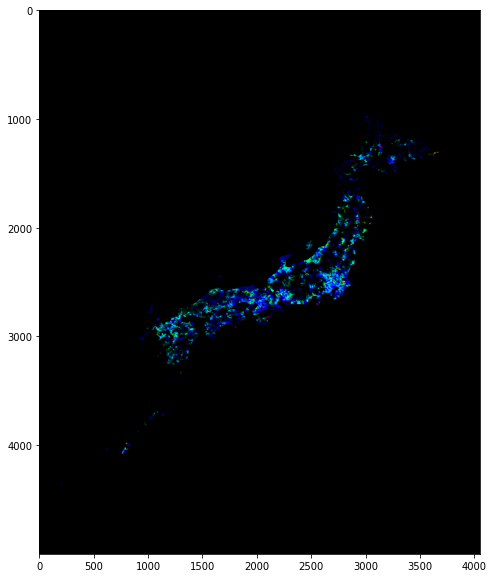

In [200]:
# seabornの設定（せっかくなのででかく表示）
sns.reset_orig()
plt.rcParams["figure.figsize"] = (10, 10)

# img_pointだけここで表示
plt.imshow(cv2.flip(img_point,0))
cv2.imwrite("/mystrage/点描.jpg", cv2.cvtColor(cv2.flip(img_point,0), cv2.COLOR_BGR2RGB))
plt.show()

# その他の画像はここで表示処理
# https://docs.opencv.org/3.2.0/d3/d50/group__imgproc__colormap.html
i = 0
for txt,img, mask, out in zip(colname_feature,img_list,mask_list,output_list):
  i+=1
  print(i, txt)
  # 擬似カラー変換
  img_hsv = cv2.applyColorMap(img, cv2.COLORMAP_HSV)
  # マスクはグレースケール化
  mask = cv2.applyColorMap(mask, cv2.COLOR_BGR2GRAY)
  # マスクを参照して、背景と欠損値にあたる箇所は黒くぬる
  img_hsv[mask==0] = [0]
  img_hsv[mask==125] = [0]
  # 画像を反転
  out = cv2.flip(img_hsv, 0)

  # 画像の出力と表示
  cv2.imwrite("/mystrage/"+txt+".jpg", cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
  plt.imshow(out)
  plt.show()


# カラースケール画像の作成

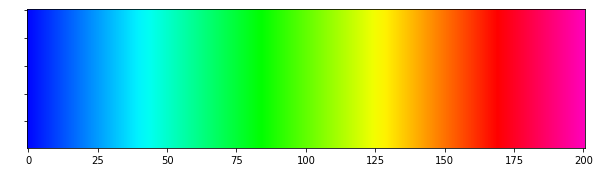

In [201]:
plt.rcParams["figure.figsize"] = (10, 10)

# 描画用画像を初期化
img_colorsample = np.zeros((50, 201, 1), np.uint8)

for i in range(255):
  for j in range(255):
    #img_colorsample = i
    cv2.circle(img_colorsample, (i,j), 1 ,i , thickness=-1)
  
img_colorsample = cv2.applyColorMap(img_colorsample, cv2.COLORMAP_HSV)
plt.imshow(img_colorsample)
plt.yticks(color="None")
plt.show()
